In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
from torchvision.transforms import functional as F
from torchvision.ops.boxes import box_iou
import random
import torchvision
import warnings

!pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


## To Do Right Now: 

# Coding/ Technical Stuff to add to paper
### Figure out why the effecient det infers bad values for bounding boxes but still gets good mAP on train/valid func. Print out the preds in valid loop and caluclate iou on them and see what happens. Compare to the infer phenomena.

### Once finished with effecient det can create ensemble model that only output boxes that are both predicted or nearly predicted by both models. If mobile net outputs 0 bboxes than run eff det and see if any boudning boxes have a good score.
https://github.com/rwightman/efficientdet-pytorch
https://github.com/rwightman/efficientdet-pytorch/blob/abba1d5a3611471ac88d49a473f993f72f9e1aba/effdet/config/model_config.py

### Find links to put saved model and weights into rasberry pi model

# Paper

### Work on creating a slide presentation to keep the paper contents.

### Move to .py script

### Labeling the other data. 




In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/LatestFruit Defects Dataset .zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("/content/drive/MyDrive/noisy_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)
rottenStrawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch1RottenStrawBerryLabels/RottenStrawberriesBatch1Labels.csv", header = None)
rottenStrawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch2RottenStrawBerryLabels/RottenStrawBerryBatch2.csv", header = None)
rottenStrawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenStrawberries/Batch3RottenStrawberrylabel/rottenStrawberryBtch3labels.csv", header = None)
freshApples_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplebtch2label/FreshApplesBatch2LabelsFresh.csv", header = None)
freshApples_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshApples/FreshApplesBatch1Labels/FreshAppleBatch1Labels.csv", header = None)
rottenTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/Rotten TomatoBatch1/Batch1TomoatosLabelsBbox.csv", header = None)
rottenTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottnTomatoBatch2/RottenTomatyoBatch2Labelss.csv", header = None)
rottenTomato_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatBtch3/RottenTomatoesBatch3Labssles.csv", header = None)
rottenTomato_csv_batch_4 = pd.read_csv("/content/Fruit Defects Dataset /Train/Rotten Tomatoes/RottenTomatoesBatch4/Tomatobatch4labelssRotten.csv", header = None)
freshTomato_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatoesBatch1Labelss/FreshTomatoesLabelsBatch1Labels.csv", header = None)
freshTomato_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/Fresh Tomatoes/FreshTomatBatch2Labessls/Batch2TomatlabelsFresh.csv", header = None)

strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenStrawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshApples_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_3.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenTomato_csv_batch_4.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_1.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
freshTomato_csv_batch_2.columns =  ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
freshTomato_csv_batch_1.drop(freshTomato_csv_batch_1[freshTomato_csv_batch_1["Image_id"] == "Fresh Tomatoes66AddonPart1.jpeg"].index, inplace = True)

strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)
freshTomato_csv_batch_1 = freshTomato_csv_batch_1.reset_index(drop = True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, 
                          rottenApple_csv_batch_2, rottenApple_csv_batch_3, rottenStrawberry_csv_batch_1, rottenStrawberry_csv_batch_2, 
                          rottenStrawberry_csv_batch_3, freshApples_csv_batch_2, freshApples_csv_batch_1, rottenTomato_csv_batch_1, 
                          rottenTomato_csv_batch_2, rottenTomato_csv_batch_3, rottenTomato_csv_batch_4, freshTomato_csv_batch_1, 
                          freshTomato_csv_batch_2]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))

def run_dataframe_check():
  assert total_row_sum_check == fruit_df.shape[0]
  print("DataFrame shape: {}".format(fruit_df.shape))
  print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
  print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))

run_dataframe_check()

#Specify more image types when 
def more_specific_Image_id(image_id, fruit):
  if fruit == "Bad_Spots":
    if re.search("RottenStrawberries", image_id):
      return "Strawberry_Bad_Spot"
    elif re.search("RottenApples", image_id):
      return "Apple_Bad_Spot"
    elif re.search("Rotten Tomatoes", image_id):
      return "Tomato_Bad_Spot"
    else:
      raise ValueError("Could not find a match for some of the Image_ids")

  else:
    return fruit

fruit_df["Fruit"] = fruit_df.apply(lambda row: more_specific_Image_id(row.Image_id, row.Fruit), axis = 1)

run_dataframe_check()

#Post Processing 
fruit_df = fruit_df[fruit_df["Image_id"] != "FreshStrawberries15.jpeg"]

bounding_box_dict = dict()
labels_dict = dict()
classes = ["Placeholder", "Apples", "Strawberry", "Tomato", "Apple_Bad_Spot", "Strawberry_Bad_Spot", "Tomato_Bad_Spot"]
# classes = ["Apples", "Strawberry", "Apple_Bad_Spot", "Strawberry_Bad_Spot"]
print(classes)
# classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))



Checked total rows from all the dataframes combined: 1882
DataFrame shape: (1882, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots' 'Tomato']
Number of Unique Images 532
DataFrame shape: (1882, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Apple_Bad_Spot' 'Strawberry_Bad_Spot' 'Tomato'
 'Tomato_Bad_Spot']
Number of Unique Images 532
['Placeholder', 'Apples', 'Strawberry', 'Tomato', 'Apple_Bad_Spot', 'Strawberry_Bad_Spot', 'Tomato_Bad_Spot']
531
531


## Class function + util functions

In [12]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  bb_coord = bb_coord.numpy()
  area_of_each_bb = list()
  for pair_of_coord in bb_coord:
    area_of_each_bb.append(
        (pair_of_coord[2] - pair_of_coord[0]) * (pair_of_coord[3] - pair_of_coord[1])
    )
  return torch.tensor(area_of_each_bb, dtype=torch.int32)

def convert_min_max(bb_coord):
  for pair_of_coord in bb_coord:
    pair_of_coord[2], pair_of_coord[3] = (pair_of_coord[0] + pair_of_coord[-2]), (pair_of_coord[1] + pair_of_coord[-1])
  return bb_coord

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode, noisy_dataset_path = None):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    if noisy_dataset_path:
      self.noisy_fp = [fp for fp in glob.glob(os.path.join(noisy_dataset_path, "*.JPEG"))]
      
      print("Noisy Has been subsetted")
      #Go to this code if you want to subset.
      self.noisy_fp = self.noisy_fp[:40]
      
    else:
      print("Dataset getting configured without noise loader")
      self.noisy_fp = list()

    # np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
      if noisy_dataset_path:
        print("Extended {} noisy images to train set".format(int(len(self.noisy_fp) * 0.8)))
        self.imgs_key.extend(self.noisy_fp[:int(len(self.noisy_fp) * 0.8)])
    elif (mode == "test"):
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]
      if noisy_dataset_path:
        print("Extended {} noisy images to test set".format(int(len(self.noisy_fp) * 0.2)))
        self.imgs_key.extend(self.noisy_fp[int(len(self.noisy_fp) * 0.8):])
    else:
      raise ValueError("Invalid Mode choose from train or test")

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_key = self.imgs_key[idx]
    if img_key in self.noisy_fp:
      img_path = img_key
      boxes = torch.zeros((0, 4), dtype=torch.float32)
      labels = torch.as_tensor([], dtype = torch.int64)
    else:
      img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
      boxes = convert_min_max(torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32))
      labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }

      sample = self.transforms(**sample)
      img = sample['image']

      if img_key not in self.noisy_fp:
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [32]:

#The Drawing function.
# COLORS = [(255, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0)]
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i] % len(COLORS)]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        if put_text:
          cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                      lineType=cv2.LINE_AA)
    return image

# Albumentations
def get_transforms(mode):
  if (mode == "train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      # A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), p=1),
                      # ToTensor(),
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "test"):
    return A.Compose([
                      # A.Resize(512, 512), 
                      # A.Normalize(mean=(0.485, 0.456, 0.406),
                      # std=(0.229, 0.224, 0.225), p=1),
                      # ToTensor()
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "effdet_train"):
    return A.Compose([
                      A.OneOf([
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
                      A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=0.5),
                      A.HorizontalFlip(),
                      A.VerticalFlip(), 
                      A.Resize(height = 512, width=512), 
                      ToTensorV2()
                      ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  elif (mode == "effdet_test"):
    return A.Compose([
                      A.Resize(height = 512, width = 512), 
                      ToTensorV2()])
  else:
    raise ValueError("mode is wrong value can either be train or test")

class NoiseDataset(object):

  def __init__(self, noise_file_path, size, camera_size):

    self.size = size
    self.noise_file_path = [fp for fp in glob.glob(os.path.join(noise_file_path, "*.JPEG"))]
    self.transforms = transforms.Compose([
                                          transforms.Resize((camera_size, camera_size)), 
                                          transforms.ToTensor()])
  
  def __getitem__(self, idx):

    current_file_path = self.noise_file_path[idx]
    img = Image.open(current_file_path).convert("RGB")

    img = self.transforms(img)
    return img

  def __len__(self):
    if self.size:
      return self.size
    return len(self.noise_file_path)
    

#Using this stack overflow (https://stackoverflow.com/questions/65279115/how-to-use-collate-fn-with-dataloaders)
#(Suppose for example, you want to create batches of a list of varying dimension tensors. The below code pads sequences with 0 until the maximum sequence size of the batch,)
#Collate_fn is a function that is used to process your batches before you pass it to dataloader. In my case since I have different sized images I need a way to stack batches b/c torch.stack won't work.
#So I use zip which can accept tensors of different lengths and make them stacked with the size of the lowest length list given. Therefore stacking all the images in a batch 
#Successfully unlike torch.stack and doing that processing to every batch makes collate_fn vital since I have different image sizes.

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

train_batch_size = 2
test_batch_size = 2
noise_path = "/content/noisy_dataset"

train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "train"), mode = "train", noisy_dataset_path=noise_path)                               
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)

test_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, get_transforms(mode = "test"), mode = "test", noisy_dataset_path=noise_path)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True, collate_fn= collate_fn)

noise_dataset = NoiseDataset(noise_path, 100, 512)
noise_loader = torch.utils.data.DataLoader(noise_dataset, batch_size = test_batch_size, shuffle = True)


Noisy Has been subsetted
Extended 32 noisy images to train set
Noisy Has been subsetted
Extended 8 noisy images to test set


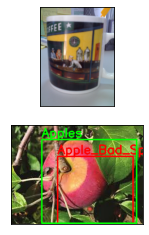

In [29]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(2):
    ax = fig.add_subplot(2, 2/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx])
    plt.imshow(image)

## What we learned
is that the model outputs losses when in train mode 
when in model.eval model, the model code then return only a prediction with no losses.

In [15]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)
    mAR = tp / (tp+fn)

    return mAP, mAR

def run_metrics_for_batch(output, targets, mAP, mAR, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      curr_mAP, curr_mAR = calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
  
  return mAP, mAR, missed_images

# def run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, mAP, mAR, missed_images, device):
#     assert (len(scores) == len(classification) == len(transformed_anchors))
#     if len(transformed_anchors) != 0:
#       curr_mAP, curr_mAR = calculate_metrics(targets[0][:, :4], transformed_anchors, scores, device)
#       mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
#     else:
#       missed_images += 1 
      
#     return mAP, mAR, missed_images


In [ ]:
def train(net, epochs, train_loader, test_loader, noise_loader, lr, weight_decay, 
          print_every = 6, lo_test_dataset = len(test_dataset), lo_train_dataset = len(train_dataset),
          lo_noise_dataset = len(noise_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    # optimizer = Ranger(net.parameters(), lr = lr, weight_decay= weight_decay)
    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            net.train()

            steps += 1
            
            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            train_mAP, train_mAR, missed_train_images = run_metrics_for_batch(net(images), targets, train_mAP, train_mAR, missed_train_images, device)
            net.train()

            losses.backward()
            # optimizer.step()

            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = correct_missed_images = 0

                for noise_images in noise_loader:
                  
                  net.eval()
                  if device == torch.device("cuda"):
                    noise_images = [noise_image.to(device) for noise_image in noise_images]
                  
                  output = net(noise_images)

                  for ii in range(len(output)):
                    if len(output[ii]["boxes"]) == 0:
                      correct_missed_images += 1

                for images, targets in test_loader:

                  net.eval()
                  if device == torch.device("cuda"):
                    images = [image.to(device) for image in images]
                    targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

                  output = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_batch(output, targets, test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  test_loss_dict = net(images, targets)
                  test_losses = sum(loss for loss in test_loss_dict.values())
                  test_loss += test_losses.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Missed Test Images: {} | Seperate Noise Loader: {} / {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100.,missed_test_images,
                    correct_missed_images, lo_noise_dataset))

              assert (steps % print_every) == 0
              train_loss = 0
                 
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))

    return net

# Effecient Det Code

In [ ]:
!pip install timm
!pip install effdet
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, unwrap_bench
from effdet.efficientdet import HeadNet
from effdet.data.transforms import *

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

MAX_NUM_INSTANCES = 100
class DetectionFastCollate:
    """ A detection specific, optimized collate function w/ a bit of state.
    Optionally performs anchor labelling. Doing this here offloads some work from the
    GPU and the main training process thread and increases the load on the dataloader
    threads.
    """
    def __init__(
            self,
            instance_keys=None,
            instance_shapes=None,
            instance_fill=-1,
            max_instances=MAX_NUM_INSTANCES,
            anchor_labeler=None,
    ):
        instance_keys = instance_keys or {'bbox', 'bbox_ignore', 'cls'}
        instance_shapes = instance_shapes or dict(
            bbox=(max_instances, 4), bbox_ignore=(max_instances, 4), cls=(max_instances,))
        self.instance_info = {k: dict(fill=instance_fill, shape=instance_shapes[k]) for k in instance_keys}
        self.max_instances = max_instances
        self.anchor_labeler = anchor_labeler

    def __call__(self, batch):

        # print(batch[0][2])
        # print(type(batch[0][2]))
        
        batch_size = len(batch)
        target = dict()
        labeler_outputs = dict()
        img_tensor = torch.zeros((batch_size, *batch[0][0].shape), dtype=torch.uint8)
        mAP_translated_boxes = list()

        for i in range(batch_size):
            img_tensor[i] += torch.from_numpy(batch[i][0])
            mAP_translated_boxes.append(torch.from_numpy(batch[i][2]))
            labeler_inputs = {}
            for tk, tv in batch[i][1].items():
                instance_info = self.instance_info.get(tk, None)
                if instance_info is not None:
                    # target tensor is associated with a detection instance
                    tv = torch.from_numpy(tv).to(dtype=torch.float32)
                    if self.anchor_labeler is None:
                        if i == 0:
                            shape = (batch_size,) + instance_info['shape']
                            target_tensor = torch.full(shape, instance_info['fill'], dtype=torch.float32)
                            target[tk] = target_tensor
                        else:
                            target_tensor = target[tk]
                        num_elem = min(tv.shape[0], self.max_instances)
                        target_tensor[i, 0:num_elem] = tv[0:num_elem]
                    else:
                        # no need to pass gt tensors through when labeler in use
                        if tk in ('bbox', 'cls'):
                            labeler_inputs[tk] = tv
                else:
                    # target tensor is an image-level annotation / metadata
                    if i == 0:
                        # first batch elem, create destination tensors
                        if isinstance(tv, (tuple, list)):
                            # per batch elem sequence
                            shape = (batch_size, len(tv))
                            dtype = torch.float32 if isinstance(tv[0], (float, np.floating)) else torch.int32
                        else:
                            # per batch elem scalar
                            shape = batch_size,
                            dtype = torch.float32 if isinstance(tv, (float, np.floating)) else torch.int64
                        target_tensor = torch.zeros(shape, dtype=dtype)
                        target[tk] = target_tensor
                    else:
                        target_tensor = target[tk]
                    target_tensor[i] = torch.tensor(tv, dtype=target_tensor.dtype)

            if self.anchor_labeler is not None:
                cls_targets, box_targets, num_positives = self.anchor_labeler.label_anchors(
                    labeler_inputs['bbox'], labeler_inputs['cls'], filter_valid=False)
                if i == 0:
                    # first batch elem, create destination tensors, separate key per level
                    for j, (ct, bt) in enumerate(zip(cls_targets, box_targets)):
                        labeler_outputs[f'label_cls_{j}'] = torch.zeros(
                            (batch_size,) + ct.shape, dtype=torch.int64)
                        labeler_outputs[f'label_bbox_{j}'] = torch.zeros(
                            (batch_size,) + bt.shape, dtype=torch.float32)
                    labeler_outputs['label_num_positives'] = torch.zeros(batch_size)
                for j, (ct, bt) in enumerate(zip(cls_targets, box_targets)):
                    labeler_outputs[f'label_cls_{j}'][i] = ct
                    labeler_outputs[f'label_bbox_{j}'][i] = bt
                labeler_outputs['label_num_positives'][i] = num_positives
        if labeler_outputs:
            target.update(labeler_outputs)

        return img_tensor, target, mAP_translated_boxes

In [53]:
class EffdetFruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms, mode, yxyx = True):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())

    np.random.shuffle(self.imgs_key)
    if (mode == "train"):
      self.imgs_key = self.imgs_key[:int(len(self.imgs_key) * 0.8)]
    else:
      self.imgs_key = self.imgs_key[int(len(self.imgs_key) * 0.8):]

    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms
    self.yxyx = yxyx

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths) 
    # img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img = Image.open(img_path).convert("RGB")
    boxes = convert_min_max(self.id_bounding_boxes[self.imgs_key[idx]])
    #boxes in xyxy format
    mAP_testable_bbox = np.array(boxes)
    
    labels = self.id_labels[self.imgs_key[idx]]
    
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels

    width, height = img.size
    target = dict(img_idx=idx, img_size=(width, height))

    bboxes = []
    labels = []

    ann ={}
    ann['bbox'] = boxes
    ann['label'] = labels

    for ann in boxes:
            ignore = False
            x1, y1, x2, y2 = ann
            label = 1
            w = x2 - x1
            h = y2 - y1
            if w < 1 or h < 1:
                ignore = True

            bbox = ann

            if self.yxyx:
              bbox = [y1, x1, y2, x2]
            
            bboxes.append(bbox)
            labels.append(label)


    bboxes = np.array(bboxes, ndmin=2, dtype=np.float32) - 1


    labels = np.array(labels, dtype=np.float32)

    ann = dict(
            bbox=bboxes.astype(np.float32),
            cls=labels.astype(np.int64))

    target.update(ann)

    if self.transforms is not None:
        img, target = self.transforms(img, target)
    
    #mAP_testable_bbox = target["bbox"]

    return img, target, mAP_testable_bbox

  def __len__(self):
    return len(self.imgs_key)

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
IMAGENET_INCEPTION_MEAN = (0.5, 0.5, 0.5)
IMAGENET_INCEPTION_STD = (0.5, 0.5, 0.5)

def run_metrics_for_batch_for_effdet(output, targets, mAP, mAR, device):

  for batch_num, _ in enumerate(output):
    boxes, scores = output[batch_num][:, :4], output[batch_num][:, 4]
    curr_target = targets[batch_num]
    if len(boxes) == 0:
      raise RuntimeError("Cannot run metrics on an empty box")
    
    curr_mAP, curr_mAR = calculate_metrics(curr_target, boxes, scores, device)
    mAP += curr_mAP
    mAR += curr_mAR 
  
  return mAP, mAR



In [54]:
def define_effdet_parameters():
  global image_size
  global model_name
  global num_cls
  global pretrained
  global pretrained_backbone
  global redundant_bias
  global label_smoothing
  global legacy_focal 
  global jit_loss
  global soft_nms
  global bench_labeler

  image_size = 640
  model_name = "efficientdet_q1"
  num_cls = 6
  pretrained=True
  pretrained_backbone=True
  redundant_bias=None
  label_smoothing=None
  legacy_focal=None
  jit_loss=None
  soft_nms=None
  bench_labeler=None

define_effdet_parameters()

In [62]:
from effdet.anchors import Anchors, AnchorLabeler
from effdet.factory import create_model, create_model_from_config
from timm.utils import *
from contextlib import suppress
from collections import OrderedDict
from timm.models.layers import set_layer_config

model = create_model(
  model_name,
  bench_task='train',
  num_classes=num_cls,
  pretrained=pretrained,
  pretrained_backbone= pretrained_backbone,
  redundant_bias=redundant_bias,
  label_smoothing= label_smoothing,
  legacy_focal=legacy_focal,
  jit_loss=jit_loss,
  soft_nms=soft_nms,
  bench_labeler=bench_labeler,
  checkpoint_path='',
  max_det_per_image = 5, #This value should be changed. The amount of images effdet predicts. May affect mAP and mAR. 
)

amp_autocast = suppress
model_config = model.config
anchor_labeler = AnchorLabeler(
            Anchors.from_config(model_config), num_cls, match_threshold=0.5)

transform = transforms_coco_eval(
            (image_size, image_size),
            interpolation='bilinear',
            use_prefetcher=True,
            fill_color='mean',
            mean=IMAGENET_DEFAULT_MEAN,
            std=IMAGENET_DEFAULT_STD)

train_batch_size = 2
valid_batch_size = 2

eff_train_dataset = EffdetFruitDetectDataset(labels_dict, bounding_box_dict, transform, mode = "train")
eff_train_loader = torch.utils.data.DataLoader(eff_train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= DetectionFastCollate(anchor_labeler=anchor_labeler))

eff_test_dataset = EffdetFruitDetectDataset(labels_dict, bounding_box_dict, transform, mode = "test")
eff_test_loader = torch.utils.data.DataLoader(eff_test_dataset, batch_size = valid_batch_size, shuffle = True, collate_fn = DetectionFastCollate(anchor_labeler=anchor_labeler))
# eff_test_dataset_2 = EffdetFruitDetectDataset(labels_dict, bounding_box_dict, transform, mode = "test", yxyx=False)
# eff_test_loader_2 = torch.utils.data.DataLoader(eff_test_dataset_2, batch_size = valid_batch_size, shuffle = True, collate_fn = DetectionFastCollate(anchor_labeler=anchor_labeler))


In [63]:
def train_epoch(
        epoch, model, loader, optimizer, 
        lr_scheduler=None, saver=None, output_dir='',  loss_scaler=None, model_ema=None):
  
    if torch.cuda.is_available():
      model.cuda()
    else:
      warnings.warn("Function does not support handling models on CPU")

    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()

    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    for batch_idx, (input, target, _) in enumerate(loader):
        last_batch = batch_idx == last_idx
        data_time_m.update(time.time() - end)

        input = input.cuda().float()
        target2={}
        for k,v in target.items():
          target2[k]=v.cuda()
  

        with amp_autocast():
          output = model(input, target2)
        loss = output['loss']

        losses_m.update(loss.item(), input.size(0))

        optimizer.zero_grad()
 
        loss.backward()
        # optimizer.first_step(zero_grad = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # with amp_autocast():
        #   output = model(input, target2)
        # loss = output['loss']
        # loss.backward()
        # optimizer.second_step(zero_grad = True)

        torch.cuda.synchronize()
        num_updates += 1
        # scheduler.step()

        batch_time_m.update(time.time() - end)
        if last_batch or batch_idx % 10 == 0:
            lrl = [param_group['lr'] for param_group in optimizer.param_groups]
            lr = sum(lrl) / len(lrl)

            print(
                'Train: {} [{:>4d}/{} ({:>3.0f}%)]  '
                'Loss: {loss.val:>9.6f} ({loss.avg:>6.4f})  '
                'Time: {batch_time.val:.3f}s, {rate:>7.2f}/s  '
                '({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                'LR: {lr:.3e}  '
                'Data: {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                    epoch,
                    batch_idx, len(loader),
                    100. * batch_idx / last_idx,
                    loss=losses_m,
                    batch_time=batch_time_m,
                    rate=input.size(0) * 1 / batch_time_m.val,
                    rate_avg=input.size(0) * 1  / batch_time_m.avg,
                    lr=lr,
                    data_time=data_time_m))


        end = time.time()



    if hasattr(optimizer, 'sync_lookahead'):
        optimizer.sync_lookahead()

    return OrderedDict([('loss', losses_m.avg)])

from itertools import chain

#Changed the evaluator argument.
def validate(bench, model, loader, valid_batch_size, args, log_suffix=''):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        valid_mAP, valid_mAR, steps = 0, 0, 0
      #Changed this line 
        for (input, target, mAP_formatted_target) in loader:
            steps += 1 
            input = input.cuda().float()
            target2={}
            for k,v in target.items():
              target2[k]=v.cuda()
            
            #Get mAP and mAR (Can possibly add some thresholding to this value)
            pred = bench(input)
            mAP_formatted_target = [tensor.cuda() for tensor in mAP_formatted_target]
            valid_mAP, valid_mAR = run_metrics_for_batch_for_effdet(pred, mAP_formatted_target, valid_mAP, valid_mAR, device)

            #Get Test Loss
            output = model(input, target2)
            loss = output['loss']
            reduced_loss = loss.data

            torch.cuda.synchronize()

            losses_m.update(reduced_loss.item(), input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()

    num_of_images_tested = valid_batch_size * steps
    metrics = OrderedDict([('loss', losses_m.avg), ("Valid mAP", str(int(valid_mAP / num_of_images_tested * 100)) + "%"), ("Valid mAR", str(int(valid_mAR / num_of_images_tested * 100)) + "%")])
    return metrics

def create_effdet_model(checkpoint):
  pretrained=True
  pretrained = pretrained or not checkpoint  # might as well try to validate something
  with set_layer_config(scriptable='store_true'):
    bench = create_model(
              model_name,
              bench_task='predict',
              num_classes=num_cls,
              pretrained=pretrained,
              pretrained_backbone=pretrained_backbone,
              redundant_bias=redundant_bias,
              label_smoothing=label_smoothing,
              legacy_focal=legacy_focal,
              jit_loss=jit_loss,
              soft_nms=soft_nms,
              bench_labeler=bench_labeler,
              checkpoint_path=checkpoint, 
              max_det_per_image = 5
          )
    
  bench.cuda()
  bench.eval()

  return bench


Train: 6 [ 211/212 (100%)]  Loss:  0.727989 (0.7556)  Time: 0.172s,   11.60/s  (0.175s,   11.41/s)  LR: 1.000e-04  Data: 0.029 (0.031)
train OrderedDict([('loss', 0.7555575621015621)])
test OrderedDict([('loss', 1.0847256957927598), ('Valid mAP', '47%'), ('Valid mAR', '77%')])


Ranger:


In [64]:
from timm.utils import get_outdir

torch.backends.cudnn.benchmark = True
saving_folder = "exp14"

output_dir = get_outdir('/content', 'train', saving_folder)
mAP_helper_checkpoints_dir = get_outdir('/content', 'mAP', saving_folder)
eval_metric='loss'
decreasing = True if eval_metric == 'loss' else False

optimizer= torch.optim.AdamW(model.parameters(), lr=.0001)
# base_optimizer = torch.optim.AdamW
# optimizer = sam.SAM(model.parameters(), base_optimizer, lr = .0001)

# optimizer = Ranger(model.parameters(), lr = 0.0001, weight_decay = 1e-5)

saver = CheckpointSaver(
model, optimizer, args=None, model_ema=None, amp_scaler=None,
checkpoint_dir=output_dir, decreasing=decreasing, unwrap_fn = unwrap_bench)

saver_for_mAP_calc = CheckpointSaver(
    model, optimizer, args = None, model_ema = None, amp_scaler = None,
    checkpoint_dir = mAP_helper_checkpoints_dir, decreasing=decreasing, unwrap_fn = unwrap_bench)


#Change this for epochs.
epochs = 8

for epoch in range(0, epochs):

  train_eval_metrics= train_epoch(
          epoch , model, eff_train_loader, optimizer,saver=saver)
  print('train',train_eval_metrics)

  #Saved prev trained model
  saver_for_mAP_calc.save_checkpoint(epoch = epoch, metric = train_eval_metrics["loss"])

  checkpoint = os.path.join(mAP_helper_checkpoints_dir,"last.pth.tar")
  bench = create_effdet_model(checkpoint)
  valid_eval_metrics = validate(bench, model, eff_test_loader, valid_batch_size, args = None)

  #Make sure to uncomment this line for saving the model
  best_metric, best_epoch = saver.save_checkpoint(epoch=epoch,metric=valid_eval_metrics['loss'])

  print('test',valid_eval_metrics)
  print('')


Train: 0 [   0/212 (  0%)]  Loss:  2.136421 (2.1364)  Time: 0.440s,    4.55/s  (0.440s,    4.55/s)  LR: 1.000e-04  Data: 0.050 (0.050)
Train: 0 [  10/212 (  5%)]  Loss:  1.754273 (1.8219)  Time: 0.444s,    4.51/s  (0.423s,    4.73/s)  LR: 1.000e-04  Data: 0.078 (0.052)
Train: 0 [  20/212 (  9%)]  Loss:  1.662248 (1.6926)  Time: 0.427s,    4.68/s  (0.421s,    4.75/s)  LR: 1.000e-04  Data: 0.066 (0.052)
Train: 0 [  30/212 ( 14%)]  Loss:  1.328310 (1.6009)  Time: 0.409s,    4.88/s  (0.420s,    4.77/s)  LR: 1.000e-04  Data: 0.042 (0.051)
Train: 0 [  40/212 ( 19%)]  Loss:  1.199301 (1.5416)  Time: 0.422s,    4.74/s  (0.419s,    4.77/s)  LR: 1.000e-04  Data: 0.042 (0.050)
Train: 0 [  50/212 ( 24%)]  Loss:  1.091582 (1.4824)  Time: 0.412s,    4.85/s  (0.422s,    4.74/s)  LR: 1.000e-04  Data: 0.046 (0.051)
Train: 0 [  60/212 ( 28%)]  Loss:  1.048268 (1.4234)  Time: 0.413s,    4.85/s  (0.421s,    4.75/s)  LR: 1.000e-04  Data: 0.051 (0.051)
Train: 0 [  70/212 ( 33%)]  Loss:  1.108536 (1.3895)  T

In [83]:
best_effdet_model = create_effdet_model("/content/train/exp14/last.pth.tar")


In [84]:
def infer_on_effdet_output(image_file_path, trained_bench):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  torch_image = F.resize(F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device), [image_size, image_size])
  output = trained_bench(torch_image)

  results = dict()

  results["boxes"] = output[0, :, :4]
  results["labels"] = output[0, :, 4]
  results["scores"] = output[0, :, -1]

  print(results)

  # print(results)
  # print(torch_image.size())

  # torch_image = draw_boxes(results["boxes"], int(results["labels"]), torch_image.squeeze(0).cpu(), infer = False, put_text = True)
  # plt.imshow(torch_image)

  return results

In [85]:
infer_on_effdet_output("/content/Fruit Defects Dataset /Predict_Examples/test_image.jpg", best_effdet_model)

{'boxes': tensor([[-2.8757e+04, -6.2381e+05, -2.8757e+04,  4.3569e+05],
        [-2.0561e+04,        -inf, -2.0561e+04,         inf],
        [-1.6797e+05,        -inf, -1.6797e+05,         inf],
        [-2.5736e+04, -9.5589e+04, -2.5736e+04, -8.7420e+03],
        [-1.2306e+04, -2.7851e+28, -1.2306e+04,  2.7851e+28]], device='cuda:0',
       grad_fn=<SliceBackward>), 'labels': tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward>), 'scores': tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward>)}


{'boxes': tensor([[-2.8757e+04, -6.2381e+05, -2.8757e+04,  4.3569e+05],
         [-2.0561e+04,        -inf, -2.0561e+04,         inf],
         [-1.6797e+05,        -inf, -1.6797e+05,         inf],
         [-2.5736e+04, -9.5589e+04, -2.5736e+04, -8.7420e+03],
         [-1.2306e+04, -2.7851e+28, -1.2306e+04,  2.7851e+28]], device='cuda:0',
        grad_fn=<SliceBackward>),
 'labels': tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward>),
 'scores': tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward>)}

# The Mobile Net Model

In [ ]:
backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
backbone.roi_heads.box_predictor.cls_score.out_features = 6
backbone.roi_heads.box_predictor.bbox_pred.out_features = 24
# backbone.roi_heads.box_predictor.cls_score.out_features = 3
# backbone.roi_heads.box_predictor.bbox_pred.out_features = 12


In [ ]:
another_one_1 = train(backbone, 5, train_loader, test_loader, noise_loader, 0.001, weight_decay = 1e-4, print_every = 80)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.001
    k: 6
    lr: 0.001
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/5 | Batch Number: 80 | LR: 0.00099 | Train_loss: 106.89 | Test_loss: 62.96 | Test mAP: 43.39% | Missed Test Images: 0 | Seperate Noise Loader: 5 / 100
Epoch 1/5 | Batch Number: 160 | LR: 0.00095 | Train_loss: 66.04 | Test_loss: 51.57 | Test mAP: 41.02% | Missed Test Images: 0 | Seperate Noise Loader: 3 / 100

 Epoch 1 Final Train mAP: 29.55% | Epoch 1 Final Missed Train Images: 1 out of 456 images 

Epoch 2/5 | Batch Number: 80 | LR: 0.00083 | Train_loss: 54.52 | Test_loss: 58.23 | Test mAP: 45.46% | Missed Test Images: 1 | Seperate Noise Loader: 8 / 100
Epoch 2/5 | Batch Number: 160 | LR: 0.00074 | Train_loss: 54.63 | Test_loss: 65.66 | Test mAP: 45.21% | Missed Test Images: 2 | Seperate Noise Loader: 19 / 100

 Epoch 2 Final Train mAP: 33.25% | Epoch 2 Final Missed Train Images: 4 out of 456 images 

Epoch 3/5 | Batch Number: 80 | LR: 0.00055 | Train_loss: 59.18 | Test_loss: 57.74 | Test mAP: 29.91% | Missed Test Images: 1 | Seperate Noise Loader: 28 / 100
Epoch 3/5 | Batch N

In [ ]:
another_one = train(backbone, 10, train_loader, test_loader, 0.001, weight_decay = 1e-4, print_every = 80)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.001
    k: 6
    lr: 0.001
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/10 | Batch Number: 80 | LR: 0.00100 | Train_loss: 109.40 | Test_loss: 50.10 | Test mAP: 34.56% | Test mAR: nan% | Missed Test Images: 0
Epoch 1/10 | Batch Number: 160 | LR: 0.00099 | Train_loss: 60.02 | Test_loss: 55.98 | Test mAP: 37.12% | Test mAR: nan% | Missed Test Images: 0

 Epoch 1 Final Train mAP: 30.74% | Epoch 1 Final Train mAR: nan% | Epoch 1 Final Missed Train Images: 0 out of 456 images 

Epoch 2/10 | Batch Number: 80 | LR: 0.00096 | Train_loss: 58.38 | Test_loss: 57.53 | Test mAP: 60.33% | Test mAR: nan% | Missed Test Images: 1
Epoch 2/10 | Batch Number: 160 | LR: 0.00093 | Train_loss: 63.52 | Test_loss: 53.23 | Test mAP: 34.23% | Test mAR: nan% | Missed Test Images: 1

 Epoch 2 Final Train mAP: 31.06% | Epoch 2 Final Train mAR: nan% | Epoch 2 Final Missed Train Images: 6 out of 456 images 

Epoch 3/10 | Batch Number: 80 | LR: 0.00087 | Train_loss: 59.26 | Test_loss: 83.11 | Test mAP: 47.73% | Test mAR: nan% | Missed Test Images: 3
Epoch 3/10 | Batch Number: 160 |

In [ ]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def intersect(box_a, box_b):

    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_iou(box_a, box_b):

    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

def calculate_iou_on_label(results, len_of_results, iou_thresh, device):
  for current_index, _ in enumerate(results["boxes"]):
    if current_index >= len_of_results:
      break

    current_index_iou = jaccard_iou(results["boxes"][current_index].view(1, -1).to(device),
                                    results["boxes"].to(device))
    
    mask = (current_index_iou > iou_thresh) & (current_index_iou != 1)
    mask = mask.squeeze()
    for key in results:
      results[key] = results[key][~mask]

    len_of_results -= sum(mask)
  
  return results

def get_labels_categ(classes, want):
  fruit_index_list, bad_spot_index_list = list(), list()
  for ii, name in enumerate(classes):
    if re.search("Spot", name):
      bad_spot_index_list.append(ii)
    elif re.search("Placeholder", name):
      continue
    else:
      fruit_index_list.append(ii)
  
  if want == "fruit":
    return fruit_index_list
  elif want == "bad_spot":
    return bad_spot_index_list
  else:
    raise ValueError("want Type not applicable [fruit or bad_spot only]")

print(classes)
get_labels_categ(classes, "bad_spot")

['Placeholder', 'Apples', 'Strawberry', 'Tomato', 'Apple_Bad_Spot', 'Strawberry_Bad_Spot', 'Tomato_Bad_Spot']


[4, 5, 6]

In [ ]:
def infer_image(image_file_path, trained_model, distance_thresh, iou_thresh, webcam = False, show_image = True):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Just load it up as PIL. Avoid using cv2 because do not need albumentations
  if not webcam:
    torch_image = F.to_tensor(Image.open(image_file_path).convert("RGB")).unsqueeze(0).to(device)
    trained_model.to(device)
    trained_model.eval()
    print("Image Size: {}".format(torch_image.size()))

    start_time = time.time()
    results = trained_model(torch_image)
    end_time = time.time() - start_time

    print("Time of Inference {:0.2f}".format(end_time))
  else:

    torch_image = F.to_tensor(image_file_path).unsqueeze(1).to(device)

    results = trained_model(torch_image)

  valid_box_count = 0
  for ii, score in enumerate(results[0]["scores"]):
    if score < distance_thresh:
      low_index_start = ii
      break
    else:
      valid_box_count += 1

  if valid_box_count == len(results[0]["scores"]):
    low_index_start = len(results[0]["scores"])
  
  for key in results[0]:
    results[0][key] = results[0][key][:low_index_start]
  
  #This is where I place the order of the list
  fruit_spot_iou_thresh, bad_spot_iou_thresh = iou_thresh

  #Update when I get more data of fruits and when running for script beware of classes.
  bad_spot_index = [ii for ii, label in enumerate(results[0]["labels"]) if label in get_labels_categ(classes, "bad_spot")]
  fruit_index = [ii for ii, _ in enumerate(results[0]["labels"]) if ii not in bad_spot_index]

  bad_spot_results, fruit_results = dict(), dict()

  for key in results[0]:
    bad_spot_results[key], fruit_results[key] = results[0][key][[bad_spot_index]], results[0][key][[fruit_index]]

  assert len(bad_spot_results["boxes"]) == len(bad_spot_results["scores"]) == len(bad_spot_results["labels"])
  assert len(fruit_results["boxes"]) == len(fruit_results["scores"]) == len(fruit_results["labels"])

  len_of_bad_spots, len_of_fruit = len(bad_spot_results["boxes"]), len(fruit_results["boxes"])

  if len_of_bad_spots > 1:
    bad_spot_results = calculate_iou_on_label(bad_spot_results, len_of_bad_spots, bad_spot_iou_thresh, device)
  if len_of_fruit > 1:
    fruit_results = calculate_iou_on_label(fruit_results, len_of_fruit, fruit_spot_iou_thresh, device)
  
  for key in results[0]: 
    if (key == "boxes"):
      results[0]["boxes"] = torch.cat((fruit_results["boxes"], bad_spot_results["boxes"]), axis = 0)
    else:
      results[0][key] = torch.cat((fruit_results[key], bad_spot_results[key]), dim = 0)

  if show_image:
    if device == torch.device("cuda"):
      torch_image = torch_image.cpu() 
    written_image = cv2.cvtColor(draw_boxes(results[0]["boxes"], results[0]["labels"], torch_image.squeeze(), infer = True, put_text= True), cv2.COLOR_BGR2RGB)
    plt.imshow(written_image)
  
  return results

In [ ]:
results = infer_image("/content/tomatpred.jpg", another_one, 0.2, [0.3, 0.1])

In [ ]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      /* try changing the capture canvas and see what happens*/
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [ ]:
data_transforms = get_transforms(mode = "test")

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 

color=None
label=None
line_thickness=None
another_one.to(device).eval();
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)
    prediciton = infer_image(image, another_one, 0.03, [0.3, 0.1], webcam= True, show_image = False)

    drawing_array = np.zeros([512,512,4], dtype=np.uint8)

    for x in prediciton[0]['boxes']:

      tl = line_thickness or round(0.002 * (drawing_array.shape[0] + drawing_array.shape[1]) / 2) + 1  # line/font thickness
      color = color or [random.randint(0, 255) for _ in range(3)]
      c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
      cv2.rectangle(drawing_array, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
      if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(drawing_array, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(drawing_array, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

    drawing_array[:,:,3] = (drawing_array.max(axis = 2) > 0 ).astype(int) * 255

    drawing_PIL = Image.fromarray(drawing_array, 'RGBA')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))

    img_data = drawing_bytes

<IPython.core.display.Javascript object>